In [1]:
%matplotlib inline
%config InlineBackend.figure_format = True
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.utils.console import ProgressBar
import mrspoc 

from mrspoc import Star, Spot

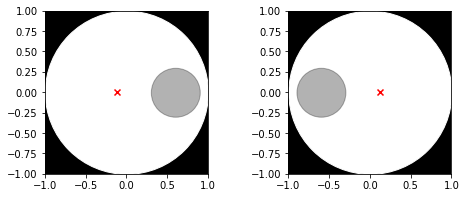

In [2]:
gj1243_t0 = Star()
gj1243_t0.spots = [Spot(x=0.6, y=0.00, r=0.30)]

gj1243_t1 = Star()
gj1243_t1.spots = [Spot(x=-0.6, y=0.00, r=0.30)]

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
gj1243_t0.plot(col=True, ax=ax[0])
gj1243_t1.plot(col=True, ax=ax[1])

In [3]:
max_photocenter_shift = 2*abs(gj1243_t0.center_of_light[0])

max_photocenter_shift

0.23750440461138841

In [101]:
from mrspoc.tgas import bv_to_radius
R_gj1243 = bv_to_radius(14.47-12.83)
print('Jitter [$\mu$AU] = {}'.format((R_gj1243 * max_photocenter_shift).to(u.uAU)))

Jitter [$\mu$AU] = 423.87370420280354 uAU


/Users/bmmorris/git/mrspoc/mrspoc/tgas.py:83: RuntimeWarning: invalid value encountered in log10
  M_V = Vmag - 5*(np.log10(dist_pc) + 1)
/Users/bmmorris/git/mrspoc/mrspoc/tgas.py:140: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(H.T), extent=extent, cmap=plt.cm.Greys, aspect=0.2)


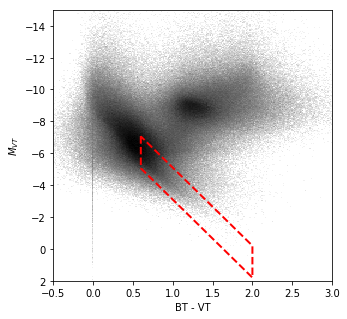

In [4]:
from mrspoc import get_table_ms
from astropy.constants import R_sun
import astropy.units as u

fig, ax = plt.subplots(figsize=(5, 5))
table = get_table_ms(ax=ax, plot=True)
fig.savefig('plots/hr.pdf', bbox_inches='tight')

In [14]:
table['R_star'] = table['R_star'].to(R_sun)

In [15]:
gj1243_teff = 3200 # estimate for sptype = M4
#R_gj1243 = 0.116 # (Mathur+, 2017) 

# Compute the apparent angular jitter due to sunspots at the
# distances of nearby MS stars in the TGAS sample
distances = table['distance']
#R_star = bv_to_radius(table['B-V'].data.data)
R_star = table['R_star']
jitter_rstar = max_photocenter_shift * R_star
sigma_jitter = np.arctan((jitter_rstar.quantity/distances.quantity).decompose()).to(u.uarcsec)

# Estimate the single-measurement astrometric error for each star
# in the TGAS sample: 
sigma_gaia = table['sigma_fov']/np.sqrt(table['N_fov'])

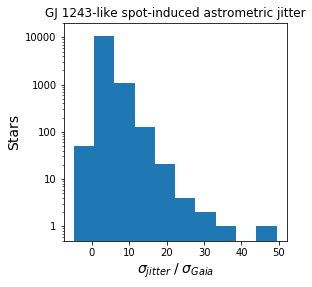

In [42]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.hist(sigma_jitter/sigma_gaia, log=True, histtype='stepfilled')
ax.set_title('GJ 1243-like spot-induced astrometric jitter')
ax.set_ylabel('Stars', fontsize=14)
ax.set_xlabel('$\sigma_{jitter} \; / \; \sigma_{Gaia}$', fontsize=14)
ax.set_ylim([0.5, 2e4])
y = [1, 10, 100, 1000, 1e4]
ax.set_yticks(y)
ax.set_yticklabels(["{0:g}".format(i) for i in y])
fig.savefig('plots/gj1243_jitter.pdf', bbox_inches='tight')

In [78]:
from astropy.table import Column, join

table.add_column(Column(data=sigma_jitter, name='sigma_jitter'))
table.add_column(Column(data=sigma_gaia, name='sigma_gaia'))
table.add_column(Column(data=(sigma_jitter/sigma_gaia).decompose(), name='snr'))

snr_gtr20 = table[table['snr'] > 20]
print("N stars:", np.count_nonzero(snr_gtr20))

N stars: 13


In [79]:
from astroquery.simbad import Simbad

sp_types = []
main_id = []
for hip_number in snr_gtr20['HIP']:
    customSimbad = Simbad()
    customSimbad.add_votable_fields('sptype')
    query = customSimbad.query_object("HIP {0}".format(hip_number))
    sp_types.append(query['SP_TYPE'][0])
    main_id.append(query['MAIN_ID'][0])

In [80]:
sptype_colname = 'Sp Type'
mainid_colname = 'main_id'

if not sptype_colname in snr_gtr20.colnames:
    snr_gtr20.add_column(Column(data=sp_types, name=sptype_colname))

if not mainid_colname in snr_gtr20.colnames:
    snr_gtr20.add_column(Column(data=main_id, name=mainid_colname))

### Activity cycle

In [83]:
from scipy.stats import anderson_ksamp, ks_2samp
from astropy.utils.console import ProgressBar

n_realizations = 1000

anderson_matrix = np.zeros((len(snr_gtr20), n_realizations))
ks_matrix = np.zeros((len(snr_gtr20), n_realizations))

with ProgressBar(n_realizations, ipython_widget=True) as bar:
    for i in range(n_realizations):
        # Observe the star N_fov times at minimum
        activity_minimum = [np.random.normal(loc=0, scale=sigma_fov, size=N_fov) 
                             for sigma_fov, N_fov in 
                             zip(snr_gtr20['sigma_fov'].to(u.uarcsec).value, 
                                 snr_gtr20['N_fov'])]

        # Observe the star N_fov times at maximum
        activity_maximum = [np.random.normal(loc=0, scale=np.sqrt(sigma_fov**2 + sigma_jitter**2), size=N_fov) 
                            for sigma_fov, sigma_jitter, N_fov in 
                            zip(snr_gtr20['sigma_fov'].to(u.uarcsec).value, 
                                snr_gtr20['sigma_jitter'], 
                                snr_gtr20['N_fov'])]

        # Compute the significance between position distributions activity minimum and maximum
        anderson = np.array([anderson_ksamp([minimum, maximum]).significance_level 
                             for minimum, maximum in zip(activity_minimum, activity_maximum)])
        ks = np.array([ks_2samp(minimum, maximum).pvalue
                       for minimum, maximum in zip(activity_minimum, activity_maximum)])

        anderson_matrix[:, i] = anderson
        ks_matrix[:, i] = ks
        bar.update()

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


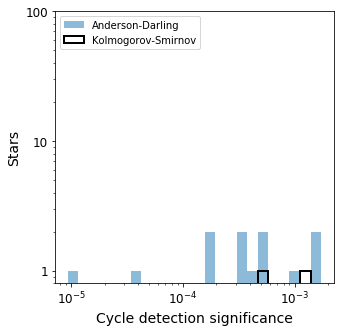

In [84]:
nbins = 25
log = True

fig, ax = plt.subplots(figsize=(5, 5))
MIN = anderson_matrix.mean(1).min()
MAX = anderson_matrix.mean(1).max()
bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), nbins)
ax.hist(anderson_matrix.mean(1), bins=bins, log=log, 
        label='Anderson-Darling', alpha=0.5, histtype='stepfilled')
ax.hist(ks_matrix.mean(1), bins=bins, histtype='step', 
        color='k', lw=2, log=log, label='Kolmogorov-Smirnov')
ax.set_xscale("log")
ax.legend(loc='upper left')
ax.set_xlabel('Cycle detection significance', fontsize=14)
ax.set_ylabel('Stars', fontsize=14)
ax.set_yticks([1, 10, 100])
ax.set_yticklabels([1, 10, 100])

plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)

ax.set_ylim([0.8, 100])
fig.savefig('plots/cycle.pdf', bbox_inches='tight')

In [85]:
pvalue_colname = 'ks'

c1 = Column(data=ks_matrix.mean(1), name=pvalue_colname)

if not pvalue_colname in snr_gtr20.colnames:    
    snr_gtr20.add_column(c1)
else: 
    snr_gtr20[pvalue_colname] = c1
    
anderson_colname = 'anderson'

c2 = Column(data=anderson_matrix.mean(1), name=anderson_colname)

if not pvalue_colname in snr_gtr20.colnames:
    snr_gtr20.add_column(c2)
else: 
    snr_gtr20[anderson_colname] = c2

In [96]:
latex_table = snr_gtr20[[mainid_colname,  'HIP', sptype_colname, 'R_star', 'rstar_ref','<Gmag>', 
                         'distance', 'sigma_fov', 'N_fov', 'sigma_jitter', 'snr', 'ks', 'anderson']]
latex_table.sort('snr')
latex_table = latex_table[::-1]
from astropy.io import ascii

ascii.write(latex_table, format='latex', output='data/candidates.tex', 
            formats={'R_star': '0.3f', 'distance': '0.2f', 'sigma_fov': '0.1f', 
                     'N_fov': '0.1f', 'sigma_jitter': '0.1f', 'snr': '0.1f', 
                     'ks': '0.1g', 'anderson': '0.1g'})

In [97]:
!cat data/candidates.tex

\begin{table}
\begin{tabular}{ccccccccccccc}
main_id & HIP & Sp Type & R_star & rstar_ref & <Gmag> & distance & sigma_fov & N_fov & sigma_jitter & snr & ks & anderson \\
 &  &  & $\mathrm{6.957 \times 10^{8}\,m}$ &  &  & $\mathrm{pc}$ & $\mathrm{\mu arcsec}$ &  & $\mathrm{\mu arcsec}$ & $\mathrm{}$ &  &  \\
V* AX Mic & 105090 & M1V & 0.589 & 1.0 & 5.881 & 3.98 & 34.2 & 107.4 & 163.3 & 49.4 & 7e-06 & 9e-06 \\
* sig Dra & 96100 & K0V & 0.789 & 1.0 & 4.711 & 5.76 & 34.2 & 58.5 & 151.2 & 33.8 & 0.001 & 0.0002 \\
V* GX And & 1475 & M2V & 0.459 & 2.0 & 7.096 & 3.56 & 34.2 & 55.6 & 142.4 & 31.0 & 0.002 & 0.0003 \\
HD  79211 & 120005 & M0V & 0.572 & 2.0 & 6.948 & 6.29 & 34.2 & 107.4 & 100.5 & 30.4 & 0.0006 & 4e-05 \\
* p Eri & 7751 & K2V+K2V & 0.787 & 1.0 & 5.581 & 8.10 & 34.2 & 76.2 & 107.4 & 27.4 & 0.002 & 0.0002 \\
LHS  3531 & 99701 & M0V & 0.564 & 1.0 & 7.134 & 6.16 & 34.2 & 69.1 & 101.1 & 24.6 & 0.005 & 0.0005 \\
HD 222237 & 116745 & K3+V & 0.772 & 1.0 & 6.669 & 11.39 & 34.2 & 107.4 & 74.

(array([ 3.,  4.,  2.,  0.,  0.,  2.,  0.,  0.,  1.,  1.]),
 array([  9.05997179e-06,   1.91044379e-04,   3.73028786e-04,
          5.55013193e-04,   7.36997600e-04,   9.18982007e-04,
          1.10096641e-03,   1.28295082e-03,   1.46493523e-03,
          1.64691964e-03,   1.82890404e-03]),
 <a list of 10 Patch objects>)

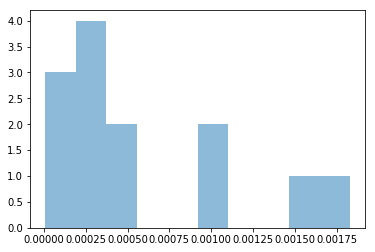

In [55]:
plt.hist(anderson_matrix.mean(1), bins=10, label='Anderson-Darling', alpha=0.5)